# Sclérose en plaques (SEP)
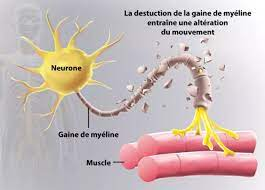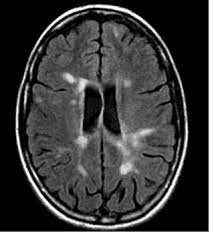

#Installation and Import of the library

La sclérose en plaques (SEP) est une maladie auto-immune : le système de défense censé protéger le patient d’agressions extérieures, se retourne contre ses propres cellules et les attaque pour des raisons encore mal connues.

Les mécanismes auto-immuns mis en jeu attaquent la gaine de myéline qui entoure les axones dans le système nerveux central. Ce phénomène entraîne des lésions dispersées dans le système nerveux central, appelées plaques : c’est de là que vient le nom de la maladie (le terme de sclérose est quant à lui historique et s’avère inadapté). Ces lésions sont le siège d’une inflammation, d’une démyélinisation et, souvent, d’une dégénérescence axonale.



Intallation of FSL's BET (Brain Extraction Tool)

In [ ]:
!pip install nibabel
!pip install nilearn

In [ ]:
pip install nipype

In [ ]:
from nipype.interfaces import fsl
import os
import cv2
import nibabel as nib
from nilearn.image import mean_img, math_img
import numpy as np
from nilearn import plotting
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import filters
from skimage import filters, exposure, restoration
from scipy.ndimage import median_filter, gaussian_filter
from skimage.restoration import denoise_tv_chambolle
from scipy.stats import norm
from scipy.optimize import curve_fit
from skimage import segmentation, color
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans
from skimage import measure
from skimage import morphology

In [ ]:
# Set the input and output directory paths
input_dir = "/content"
output_dir = "/content/output"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the files in the input directory
input_files = [f for f in os.listdir(input_dir) if f.endswith("-Flair.nii")]


In [ ]:
def load_nifti(file_path):
    """Load NIfTI file."""
    img = nib.load(file_path)
    return img.get_fdata()
def save_nifti(data, file_path, original_img):
    """Save NIfTI file."""
    img = nib.Nifti1Image(data, affine=original_img.affine)
    nib.save(img, file_path)

# Data Exploration

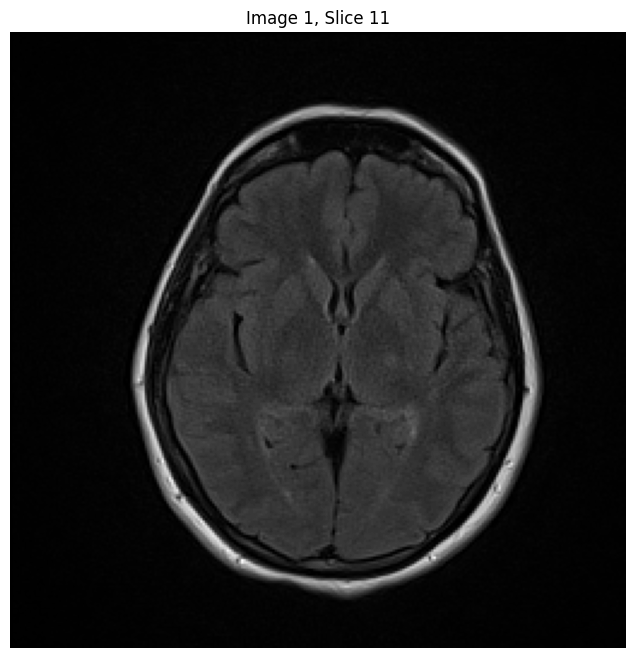

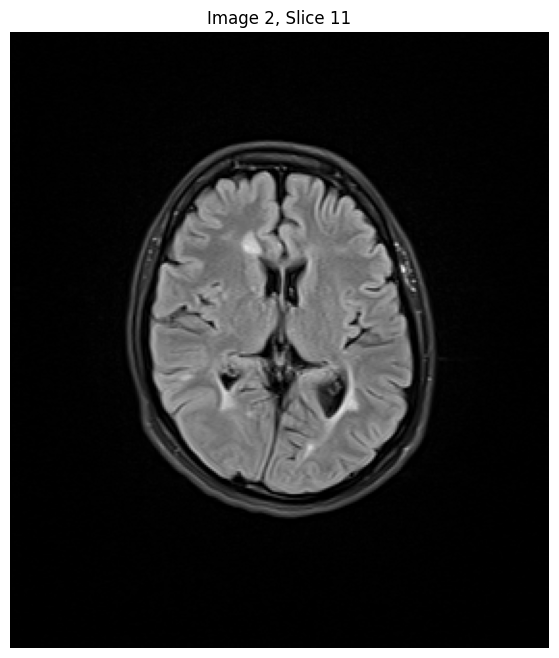

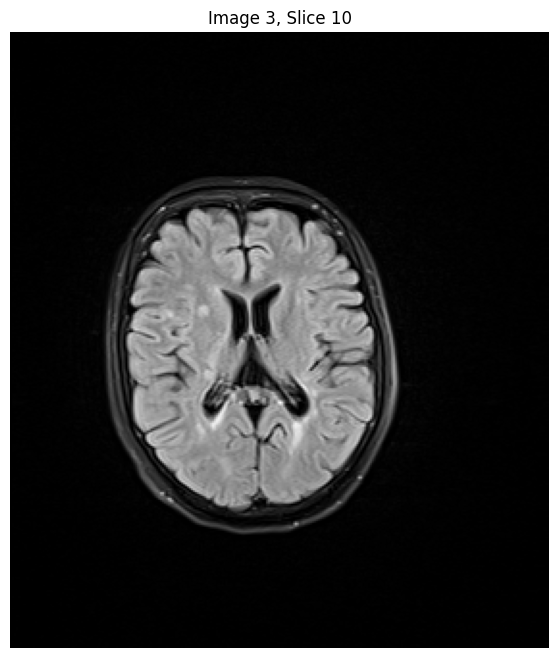

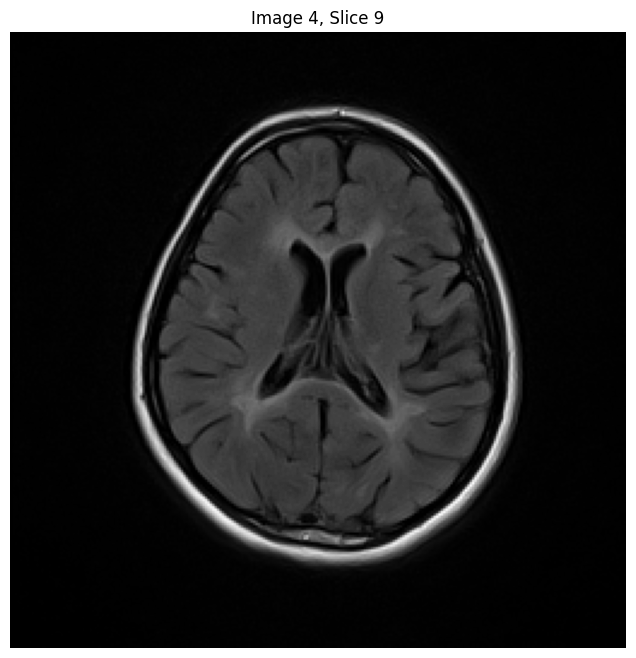

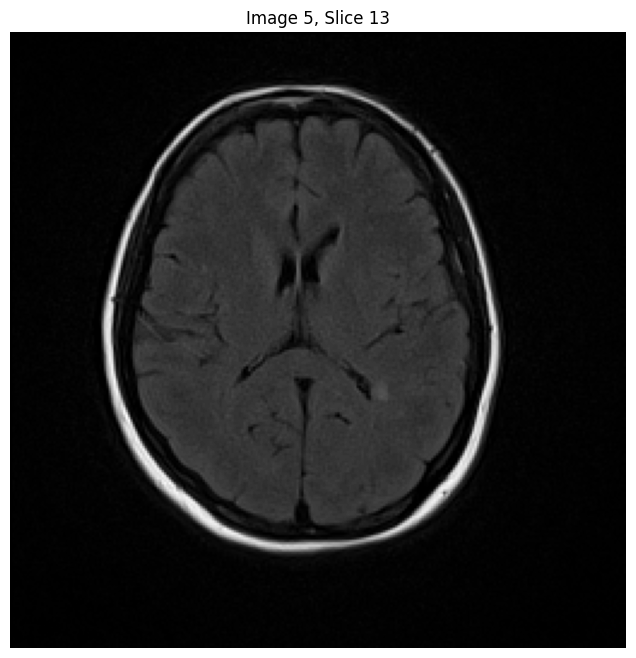

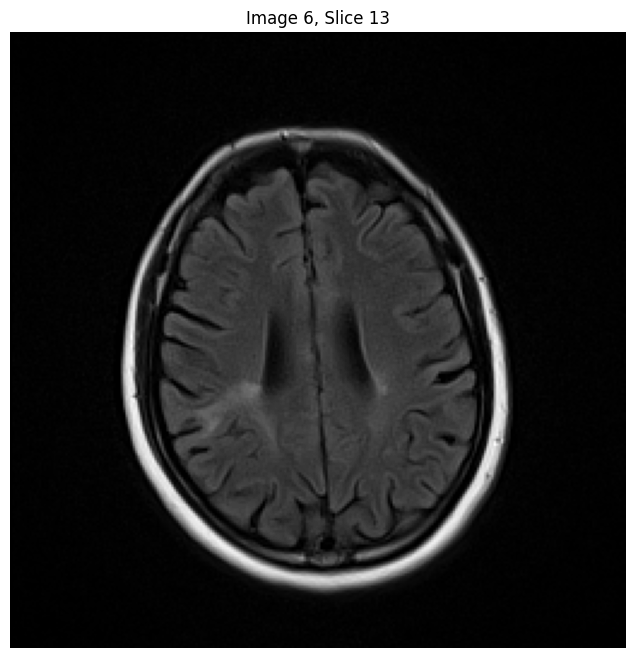

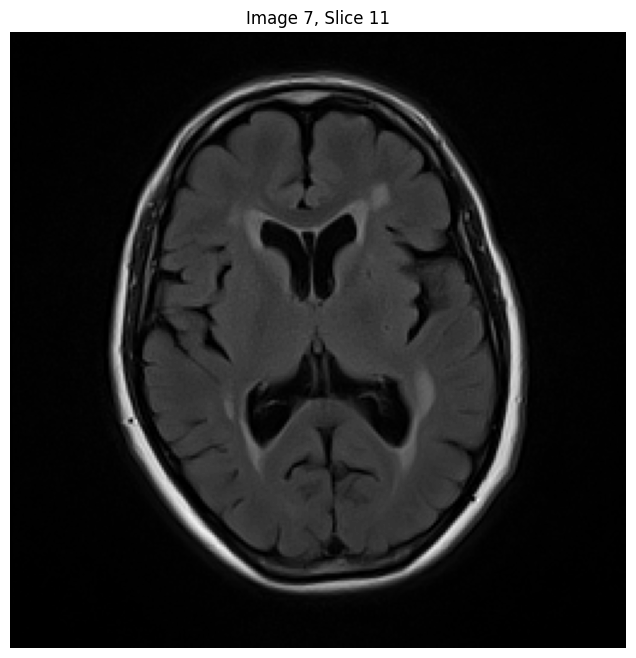

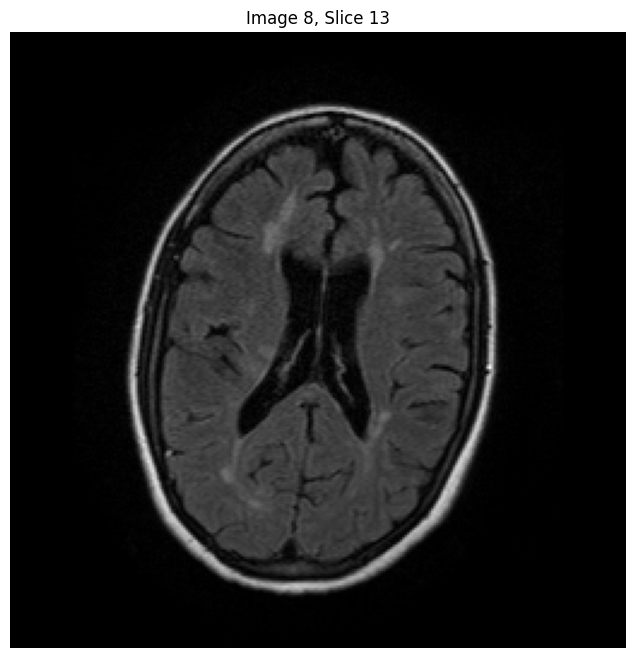

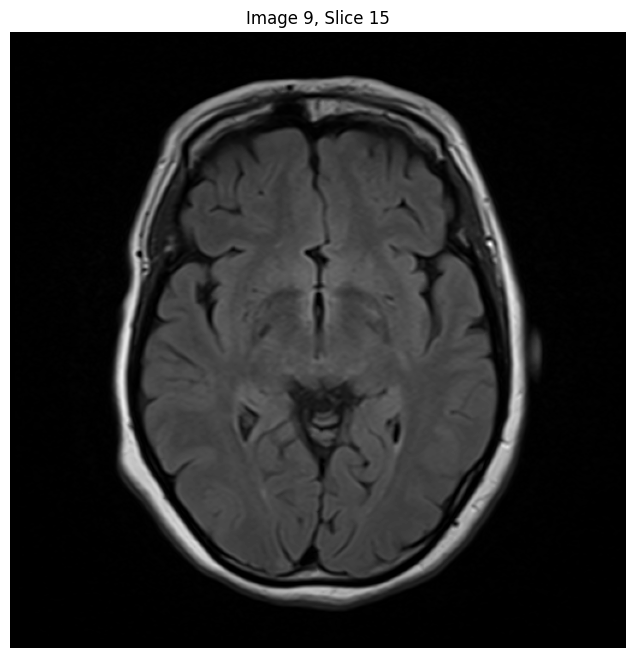

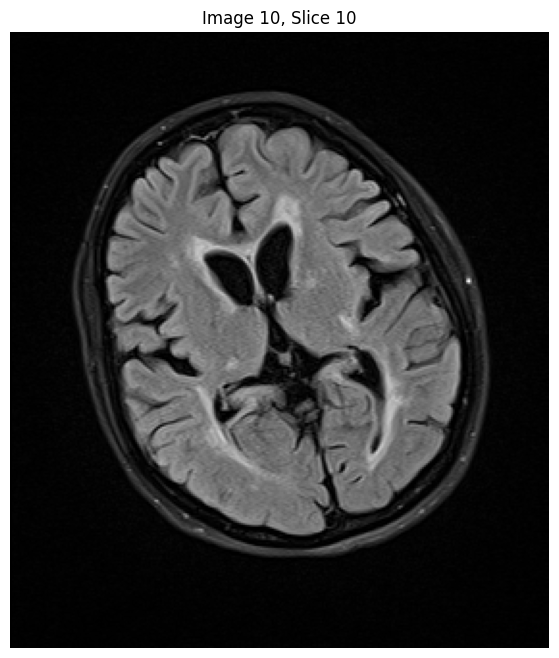

In [ ]:
# Create a list to store the loaded images
image_list = []

# Load NIfTI files in a loop
for i in range(1, 11):
    filename = f'{i}-Flair.nii'
    img = nib.load(filename)
    image_list.append(img)
# Visualize one or two slices from each image
for i, img in enumerate(image_list, start=1):
    # Select the middle slice along the third axis
    middle_slice = img.shape[2] // 2

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img.get_fdata()[:, :, middle_slice], cmap='gray')
    plt.title(f"Image {i}, Slice {middle_slice}")
    plt.axis('off')
    plt.show()

In [ ]:
# Explore the loaded images
for i, img in enumerate(image_list, start=1):
    print(f"\n=== Image {i} ===")
    print(f"Shape: {img.shape}")
    print(f"Data Type: {img.get_fdata().dtype}")
    print(f"Affine Transformation Matrix:\n{img.affine}")
    print(f"Header Information:\n{img.header}")
    print(f"Voxel Dimensions (mm): {img.header.get_zooms()}")
    print(f"Spatial Dimensions (mm): {img.header.get_xyzt_units()}")


=== Image 1 ===
Shape: (256, 256, 23)
Data Type: float64
Affine Transformation Matrix:
[[  -1.     0.     0.   127.5]
 [   0.     1.     0.  -127.5]
 [   0.     0.     1.   -11. ]
 [   0.     0.     0.     1. ]]
Header Information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b'          '
db_name         : b'                  '
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 32
dim             : [  3 256 256  23   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         

Key observations:

* Shape: The images have different dimensions, with varying numbers of slices along the third axis.

* Affine Transformation Matrix: This matrix describes the spatial transformation applied to the image. It includes translation and scaling parameters. The negative scaling factor along the first axis (-1) suggests a possible flip in that direction.

* Voxel Dimensions (mm): The voxel dimensions are uniform across all images (1.0 mm x 1.0 mm x 1.0 mm).

* Spatial Dimensions (mm): The spatial dimensions are marked as 'unknown' in the header. Typically, the dimensions should be known, and it's possible that the DICOM metadata wasn't completely transferred to the NIfTI header.

# Skull Stripping

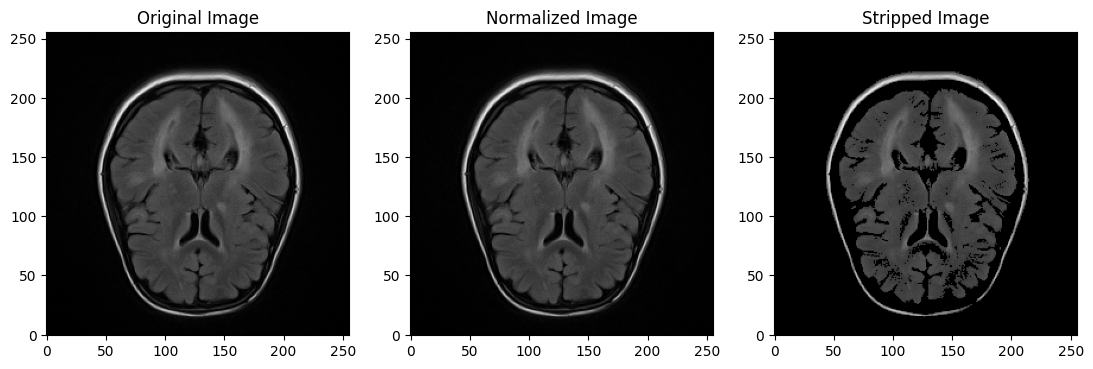

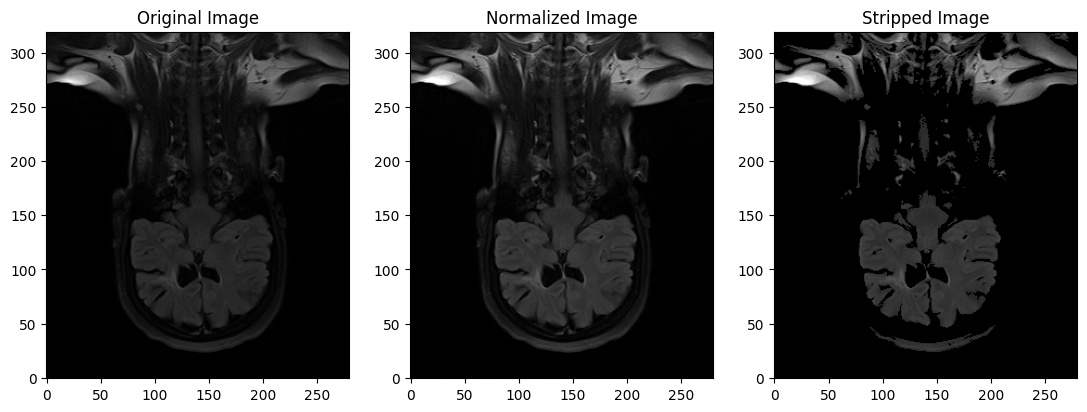

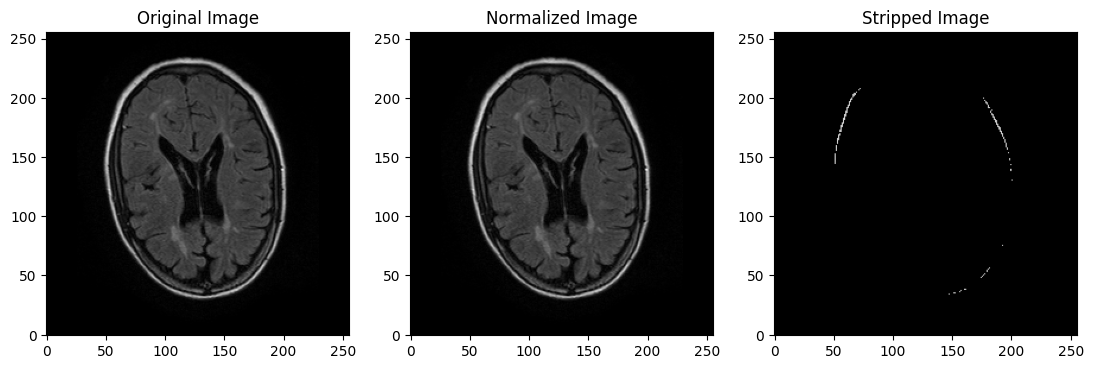

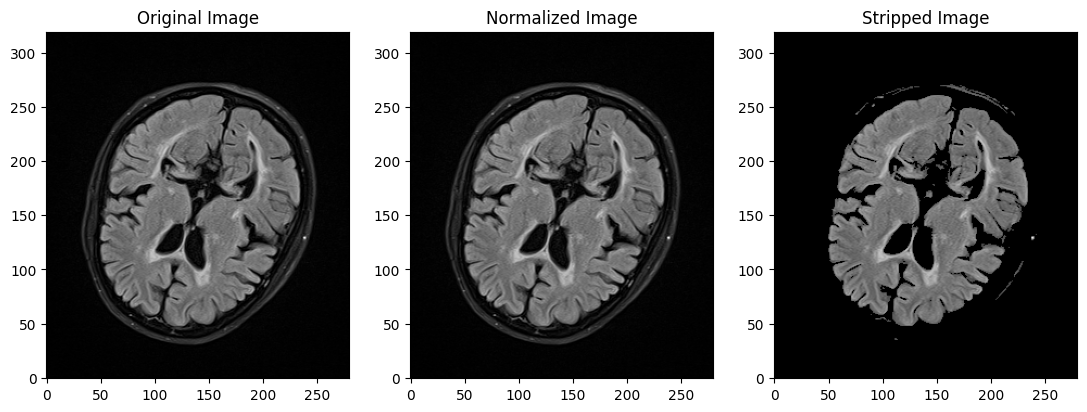

OSError: ignored

In [ ]:
from skimage import morphology, exposure
import nibabel as nib
import os
import matplotlib.pyplot as plt
from skimage import filters, morphology
from scipy import ndimage
import numpy as np

# Function to save Nifti images
def save_nifti(data, file_path, reference_img):
    nifti_img = nib.Nifti1Image(data, reference_img.affine, reference_img.header)
    nib.save(nifti_img, file_path)

# Function for intensity normalization
def normalize_intensity(image):
    normalized_data = exposure.rescale_intensity(image.get_fdata(), in_range=(0, 1500), out_range=(0, 1))
    normalized_image = nib.Nifti1Image(normalized_data, image.affine, image.header)
    return normalized_image

# Function for skull stripping with adjusted parameters
def skull_stripping(image):
    # Adjust the threshold value based on your image characteristics
    threshold_value = 0.15

    # Create a binary mask using the adjusted threshold
    binary_mask = image.get_fdata() > threshold_value

    # Remove small objects with a larger minimum size
    mask = morphology.remove_small_objects(binary_mask, min_size=100, connectivity=2)

    # Apply the mask to the original image data
    stripped_data = image.get_fdata() * mask

    # Create a new Nifti image with the stripped data
    stripped_image = nib.Nifti1Image(stripped_data, image.affine, image.header)

    return stripped_image

# Set the input and output directory paths
input_dir = "/content"
output_dir = "/content/output"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the files in the input directory
input_files = [f for f in os.listdir(input_dir) if f.endswith("-Flair.nii")]

# Loop over each input file
for input_file in input_files:
    input_file_path = os.path.join(input_dir, input_file)

    # Load the original image
    img = nib.load(input_file_path)

    # Normalize intensity
    normalized_img = normalize_intensity(img)

    # Perform skull stripping with adjusted parameters
    stripped_img = skull_stripping(normalized_img)

    # Save the stripped image
    output_file_path = os.path.join(output_dir, f"stripped_{input_file}")
    save_nifti(stripped_img.get_fdata(), output_file_path, img)

    # Visualize the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img.get_fdata()[:, :, img.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(normalized_img.get_fdata()[:, :, normalized_img.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Normalized Image")

    plt.subplot(1, 4, 3)
    plt.imshow(stripped_img.get_fdata()[:, :, stripped_img.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Stripped Image")

    plt.show()


# Contrast Enhancement

## histogram stretching

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output"
output_dir = "/content/output/preprocessed"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the stripped files in the output directory
stripped_files = [f for f in os.listdir(input_dir) if f.startswith("stripped_")]

# Loop over each stripped file
for stripped_file in stripped_files:
    stripped_file_path = os.path.join(input_dir, stripped_file)

    # Load stripped image
    stripped_img_data = nib.load(stripped_file_path).get_fdata()

    # Apply contrast enhancement
    stripped_img_data_stretched = exposure.rescale_intensity(stripped_img_data)

    # Visualize the result
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(stripped_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Stripped Image")

    plt.subplot(1, 2, 2)
    plt.imshow(stripped_img_data_stretched[:, :, stripped_img_data_stretched.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Contrast Enhancement")

    plt.show()

## logarithmic and exponential transformations

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output"
output_dir = "/content/output/preprocessed"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the stripped files in the output directory
stripped_files = [f for f in os.listdir(input_dir) if f.startswith("stripped_")]

# Loop over each stripped file
for stripped_file in stripped_files:
    stripped_file_path = os.path.join(input_dir, stripped_file)

    # Load stripped image
    stripped_img_data = nib.load(stripped_file_path).get_fdata()

    # Apply histogram stretching
    stretched_img_data = exposure.rescale_intensity(stripped_img_data)

    # Apply logarithmic transformation
    log_transformed_img_data = exposure.adjust_log(stripped_img_data)

    # Apply exponential transformation
    exp_transformed_img_data = exposure.adjust_gamma(stripped_img_data, gamma=0.4)

    # Visualize the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(stripped_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(stretched_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Histogram Stretching")

    plt.subplot(1, 4, 3)
    plt.imshow(log_transformed_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Logarithmic Transformation")

    plt.subplot(1, 4, 4)
    plt.imshow(exp_transformed_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Exponential Transformation")

    plt.show()


# Histogram Equalization:

## Global Histogram Equalization


In [ ]:
# Set the input and output directory paths
input_dir = "/content/output"
output_dir = "/content/output/preprocessed"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the stripped files in the output directory
stripped_files = [f for f in os.listdir(input_dir) if f.startswith("stripped_")]

# Loop over each stripped file
for stripped_file in stripped_files:
    stripped_file_path = os.path.join(input_dir, stripped_file)

    # Load stripped image
    stripped_img_data = nib.load(stripped_file_path).get_fdata()

    # Apply histogram stretching
    stretched_img_data = exposure.rescale_intensity(stripped_img_data)

    # Apply global histogram equalization
    equalized_img_data = exposure.equalize_hist(stretched_img_data)

    # Visualize the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(stripped_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(stretched_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Histogram Stretching")

    plt.subplot(1, 3, 3)
    plt.imshow(equalized_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Global Histogram Equalization")

    plt.show()


## Adaptive Histogram Equalization




In [ ]:
def normalize_img(img_data):
    min_val = np.min(img_data)
    max_val = np.max(img_data)
    normalized_img = (img_data - min_val) / (max_val - min_val)
    return normalized_img

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output"
output_dir = "/content/output/preprocessed"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the stripped files in the output directory
stripped_files = [f for f in os.listdir(input_dir) if f.startswith("stripped_")]

# Loop over each stripped file
for stripped_file in stripped_files:
    stripped_file_path = os.path.join(input_dir, stripped_file)

    # Load the stripped image
    stripped_img_data = load_nifti(stripped_file_path)

    # Apply histogram stretching
    stretched_img_data = exposure.rescale_intensity(stripped_img_data)

    # Normalize pixel values to the range [0, 1]
    stretched_img_data_normalized = normalize_img(stretched_img_data)

    # Apply adaptive histogram equalization
    ahe_img_data = exposure.equalize_adapthist(stretched_img_data_normalized)
    # Save the processed images
    stretched_file_path = os.path.join(output_dir, f"stretched_{stripped_file}")
    normalized_file_path = os.path.join(output_dir, f"normalized_{stripped_file}")
    ahe_file_path = os.path.join(output_dir, f"ahe_{stripped_file}")

    save_nifti(stretched_img_data, stretched_file_path, nib.load(stripped_file_path))
    save_nifti(stretched_img_data_normalized, normalized_file_path, nib.load(stripped_file_path))
    save_nifti(ahe_img_data, ahe_file_path, nib.load(stripped_file_path))


    # Visualize the results
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(stripped_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(stretched_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Histogram Stretching")

    plt.subplot(1, 4, 3)
    plt.imshow(stretched_img_data_normalized[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Normalized Image")

    plt.subplot(1, 4, 4)
    plt.imshow(ahe_img_data[:, :, stripped_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Adaptive Histogram Equalization")

    plt.show()

# Noise Removal

## Spatial Filters: Mean Filter, Median Filter, Gaussian Filter

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/preprocessed"
output_dir = "/content/output/noise_removal"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the preprocessed files in the input directory
preprocessed_files = [f for f in os.listdir(input_dir) if f.startswith("ahe_")]

# Loop over each preprocessed file
for preprocessed_file in preprocessed_files:
    preprocessed_file_path = os.path.join(input_dir, preprocessed_file)

    # Load the preprocessed image
    preprocessed_img_data = load_nifti(preprocessed_file_path)

    # Apply mean filter
    mean_filtered_img_data = cv2.blur(preprocessed_img_data, (3, 3))

    # Apply median filter
    median_filtered_img_data = median_filter(preprocessed_img_data, size=3)

    # Apply Gaussian filter
    gaussian_filtered_img_data = gaussian_filter(preprocessed_img_data, sigma=1)
    # Visualize the results
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(preprocessed_img_data[:, :, preprocessed_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(mean_filtered_img_data[:, :, preprocessed_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Mean Filter")

    plt.subplot(1, 4, 3)
    plt.imshow(median_filtered_img_data[:, :, preprocessed_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Median Filter")

    plt.subplot(1, 4, 4)
    plt.imshow(gaussian_filtered_img_data[:, :, preprocessed_img_data.shape[2] // 2], cmap="gray", origin="lower")
    plt.title("Gaussian Filter")

    plt.show()

## Non-linear Techniques: Bilateral Filtering

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/preprocessed"
output_dir = "/content/output/noise_removal"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the preprocessed files in the input directory
preprocessed_files = [f for f in os.listdir(input_dir) if f.startswith("ahe_")]

# Loop over each preprocessed file
for preprocessed_file in preprocessed_files:
    preprocessed_file_path = os.path.join(input_dir, preprocessed_file)

    # Load the preprocessed image
    preprocessed_img_data = load_nifti(preprocessed_file_path)

    # If the image has multiple channels, take a single channel (e.g., slice along an axis)
    if len(preprocessed_img_data.shape) == 3:
        preprocessed_img_data = preprocessed_img_data[:, :, preprocessed_img_data.shape[2] // 2]

    # Normalize pixel values to the range [0, 255]
    preprocessed_img_data_normalized = ((preprocessed_img_data - preprocessed_img_data.min()) /
                                         (preprocessed_img_data.max() - preprocessed_img_data.min()) * 255).astype(np.uint8)

    # Apply Non-Local Means Denoising
    nlm_denoised_img_data = cv2.fastNlMeansDenoising(preprocessed_img_data_normalized, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Save the processed image
    nlm_denoised_file_path = os.path.join(output_dir, f"nlm_denoised_{preprocessed_file}")
    save_nifti(nlm_denoised_img_data, nlm_denoised_file_path, nib.load(preprocessed_file_path))

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_img_data_normalized, cmap="gray", origin="lower")
    plt.title("Normalized Image")

    plt.subplot(1, 2, 2)
    plt.imshow(nlm_denoised_img_data, cmap="gray", origin="lower")
    plt.title("Non-Local Means Denoising")

    plt.show()

## Denoise tv chambolle

In [ ]:
input_dir = "/content/output/preprocessed"
output_dir = "/content/output/noise_removal"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the preprocessed files in the input directory
preprocessed_files = [f for f in os.listdir(input_dir) if f.startswith("ahe_")]

# Loop over each preprocessed file
for preprocessed_file in preprocessed_files:
    preprocessed_file_path = os.path.join(input_dir, preprocessed_file)

    # Load the preprocessed image
    preprocessed_img_data = load_nifti(preprocessed_file_path)

    # If the image has multiple channels, take a single channel (e.g., slice along an axis)
    if len(preprocessed_img_data.shape) == 3:
        preprocessed_img_data = preprocessed_img_data[:, :, preprocessed_img_data.shape[2] // 2]

    # Normalize pixel values to the range [0, 1]
    preprocessed_img_data_normalized = (preprocessed_img_data - preprocessed_img_data.min()) / (preprocessed_img_data.max() - preprocessed_img_data.min())

    # Apply Total Variation (TV) Chambolle Denoising
    tv_chambolle_denoised_img_data = restoration.denoise_tv_chambolle(preprocessed_img_data_normalized, weight=0.1)

    # Save the processed image
    tv_chambolle_denoised_file_path = os.path.join(output_dir, f"tv_chambolle_denoised_{preprocessed_file}")
    save_nifti(tv_chambolle_denoised_img_data, tv_chambolle_denoised_file_path, nib.load(preprocessed_file_path))

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_img_data_normalized, cmap="gray", origin="lower")
    plt.title("Normalized Image")

    plt.subplot(1, 2, 2)
    plt.imshow(tv_chambolle_denoised_img_data, cmap="gray", origin="lower")
    plt.title("TV Chambolle Denoising")

    plt.show()

# Normalization

In [ ]:
def normalize_z_nifti_2d(img_data):
    # Normalize pixel values along the second axis (axis=1)
    normalized_img_data = (img_data - np.mean(img_data, axis=1)[:, np.newaxis]) / np.std(img_data, axis=1)[:, np.newaxis]

    return normalized_img_data


In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/spatially_normalized"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)
    spatially_normalized_img_data = normalize_z_nifti_2d(denoised_img_data)


    # Save the spatially normalized image
    spatially_normalized_file_path = os.path.join(output_dir, f"spatially_normalized_{denoised_file}")
    save_nifti(spatially_normalized_img_data, spatially_normalized_file_path, nib.load(denoised_file_path))


In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/spatially_normalized"

# List all the spatially normalized files in the input directory
normalized_files = [f for f in os.listdir(input_dir) if f.startswith("spatially_normalized")]

# Loop over each normalized file
for normalized_file in normalized_files:
    normalized_file_path = os.path.join(input_dir, normalized_file)

    # Load the normalized image
    normalized_img_data = load_nifti(normalized_file_path)

    # For 2D images, simply show the image and histogram
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_img_data, cmap="gray", origin="lower")
    plt.title("Spatially Normalized Image")

    plt.subplot(1, 2, 2)
    plt.hist(normalized_img_data.flatten(), bins=50, color='c', edgecolor='k', alpha=0.7)
    plt.title("Histogram of Spatially Normalized Image")

    plt.show()


# Histogram Analysis

## Peaks and Valleys Study

In [ ]:
# Set the input directory path
input_dir = "/content/output/noise_removal"

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised_")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Flatten the pixel intensities to a 1D array
    flattened_data = denoised_img_data.flatten()

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_data, bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    # Identify peaks and valleys (local minima) in the histogram
    peaks, _ = np.histogram(flattened_data, bins=256, range=(0, 256), density=True)
    valley_indices = np.where((peaks[:-2] > peaks[1:-1]) & (peaks[2:] > peaks[1:-1]))[0] + 1
    peaks_indices = np.where((peaks[:-2] < peaks[1:-1]) & (peaks[2:] < peaks[1:-1]))[0] + 1

    # Plot peaks and valleys on the histogram
    plt.plot(valley_indices, peaks[valley_indices], 'ro', label='Valleys')
    plt.plot(peaks_indices, peaks[peaks_indices], 'go', label='Peaks')

    plt.legend()
    plt.show()

## Statistical Modeling of the Histogram

In [ ]:
# Set the input directory path
input_dir = "/content/output/noise_removal"

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised_")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Flatten the pixel intensities to a 1D array
    flattened_data = denoised_img_data.flatten()

    # Fit a Gaussian distribution to the data
    mean, std = norm.fit(flattened_data)
    # Print the results
    print(f"Results for {denoised_file}:")
    print(f"Mean: {mean:.2f}")
    print(f"Standard Deviation: {std:.2f}")
    print("-------------------------------")

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_data, bins=50, density=True, alpha=0.6, color='g')

    # Plot the fitted Gaussian distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean, std)
    plt.plot(x, p, 'k', linewidth=2)

    title = f"Fit results: Mean = {mean:.2f},  Std = {std:.2f}"
    plt.title(title)
    plt.show()

 * 1-Flair.nii:
 The spatially normalized image nlm_denoised_ahe_stripped_1-Flair.nii exhibits a mean pixel intensity of 29.90 and a standard deviation of 46.39. The mean intensity represents the average pixel brightness, providing insight into the central tendency of the image. Meanwhile, the standard deviation quantifies the spread of pixel intensities around the mean, indicating the degree of variability in the image.

## Threshold Optimization for Contrast and Brightness

In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/threshold_optimization"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Get the central slice for visualization
    central_slice = denoised_img_data.shape[2] // 2 if len(denoised_img_data.shape) > 2 else 0

    # Apply Otsu's method for thresholding
    threshold_value = filters.threshold_otsu(denoised_img_data)
    binary_mask = denoised_img_data > threshold_value

    # Save the thresholded image
    thresholded_file_path = os.path.join(output_dir, f"thresholded_{denoised_file}")
    nib.save(nib.Nifti1Image(binary_mask.astype(np.uint8), nib.load(denoised_file_path).affine), thresholded_file_path)

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    if len(denoised_img_data.shape) > 2:
        plt.imshow(denoised_img_data[:, :, central_slice], cmap="gray", origin="lower")
        plt.title("Denoised Image")
    else:
        plt.imshow(denoised_img_data, cmap="gray", origin="lower")
        plt.title("Denoised Image")

    plt.subplot(1, 3, 2)
    if len(denoised_img_data.shape) > 2:
        plt.imshow(binary_mask[:, :, central_slice], cmap="gray", origin="lower")
        plt.title("Binary Mask")
    else:
        plt.imshow(binary_mask, cmap="gray", origin="lower")
        plt.title("Binary Mask")

    plt.subplot(1, 3, 3)
    plt.hist(denoised_img_data.flatten(), bins=100, color='c', alpha=0.7, rwidth=0.85)
    plt.axvline(x=threshold_value, color='r', linestyle='--', linewidth=2, label='Otsu Threshold')
    plt.title("Histogram with Otsu Threshold")

    plt.legend()
    plt.show()

#  Segmentation

## Intensity-Based Segmentation (Thresholding)

In [ ]:
# Function to load NIfTI data
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Function to save NIfTI data
def save_nifti(data, file_path, reference_img):
    img = nib.Nifti1Image(data, reference_img.affine)
    nib.save(img, file_path)

# Set the input and output directory paths
input_dir = "/content"
output_dir = "/content/output/intensity_segmentation"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the original files in the input directory
original_files = [f for f in os.listdir(input_dir) if f.endswith("-Flair.nii")]

# Loop over each original file
for original_file in original_files:
    original_file_path = os.path.join(input_dir, original_file)

    # Load the original image
    original_img_data = load_nifti(original_file_path)

    # Get the central slice for visualization
    central_slice = original_img_data.shape[2] // 2

    # Define intensity range for thresholding
    lower_bound = 50
    upper_bound = 150

    # Apply intensity-based thresholding
    binary_mask = np.logical_and(original_img_data > lower_bound, original_img_data < upper_bound)

    # Save the segmented image
    segmented_file_path = os.path.join(output_dir, f"intensity_segmented_{original_file}")
    save_nifti(binary_mask.astype(np.uint8), segmented_file_path, nib.load(original_file_path))

    # Visualize the segmented image for a specific slice
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_data[:, :, central_slice], cmap="gray", origin="lower")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask[:, :, central_slice], cmap="gray", origin="lower")
    plt.title("Segmented Image (Intensity Thresholding)")

    # Display the plot
    plt.show()


In [ ]:
from skimage.filters import threshold_otsu

# Function to load NIfTI data
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Function to save NIfTI data
def save_nifti(data, file_path, reference_img):
    img = nib.Nifti1Image(data, reference_img.affine)
    nib.save(img, file_path)

# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/segmentation"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Define intensity range for thresholding
    lower_bound = 100
    upper_bound = 150

    # Apply intensity-based thresholding
    binary_mask = np.logical_and(denoised_img_data > lower_bound, denoised_img_data < upper_bound)

    # Save the binary segmented image
    segmented_binary_file_path = os.path.join(output_dir, f"segmented_binary_{denoised_file}")
    save_nifti(binary_mask.astype(np.uint8), segmented_binary_file_path, nib.load(denoised_file_path))

    # Visualize the results
    plt.figure(figsize=(10, 4))

    if len(denoised_img_data.shape) == 3:
        plt.subplot(1, 2, 1)
        # Visualize the original denoised image
        plt.imshow(denoised_img_data[:, :, denoised_img_data.shape[2] // 2], cmap="gray", origin="lower")
        plt.title("Denoised Image")

        plt.subplot(1, 2, 2)
        # Visualize the binary segmented image
        plt.imshow(binary_mask[:, :, denoised_img_data.shape[2] // 2], cmap="gray", origin="lower")
        plt.title("Binary Segmented Image")

    elif len(denoised_img_data.shape) == 2:
        # Visualize a single 2D image
        plt.subplot(1, 2, 1)
        plt.imshow(denoised_img_data, cmap="gray", origin="lower")
        plt.title("Denoised Image")

        plt.subplot(1, 2, 2)
        plt.imshow(binary_mask, cmap="gray", origin="lower")
        plt.title("Binary Segmented Image")

    plt.show()


## Segmentation par croissance de région (Region Growing)

In [ ]:
from skimage.segmentation import flood_fill

# Function to load NIfTI data
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Function to save NIfTI data
def save_nifti(data, file_path, reference_img):
    img = nib.Nifti1Image(data, reference_img.affine)
    nib.save(img, file_path)

# Region-growing segmentation function
def region_growing(image, seed, intensity_threshold):
    # Create a binary mask for the region
    mask = np.zeros_like(image, dtype=bool)

    # Apply region growing
    filled_image = flood_fill(image, seed, intensity_threshold, in_place=False)

    # Create a binary mask based on the filled region
    mask[filled_image == 1] = 1

    return mask

# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/region_segmentation"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    print("Shape of denoised_img_data:", denoised_img_data.shape)

    # Manually set the seed point based on the lesion location
    seed_point = (200, 250)

    # Use an adaptive thresholding approach
    intensity_threshold = denoised_img_data.mean() + denoised_img_data.std()

    # Apply a region-growing segmentation
    segmentation_result = region_growing(denoised_img_data, seed_point, intensity_threshold)

    # Save the segmented image
    segmented_file_path = os.path.join(output_dir, f"segmented_{denoised_file}")
    save_nifti(segmentation_result.astype(np.uint8), segmented_file_path, nib.load(denoised_file_path))

    # Visualize the results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(denoised_img_data, cmap="gray", origin="lower")
    plt.title("Denoised Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_result, cmap="viridis", origin="lower")
    plt.title("Segmented Image")

    plt.show()


In [ ]:
# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/region_segmentation_felzenszwalb"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Convert the image to grayscale if it's not already
    if len(denoised_img_data.shape) == 3:
        denoised_img_data = color.rgb2gray(denoised_img_data)

    # Apply Felzenszwalb's efficient graph-based segmentation
    segmentation_result = segmentation.felzenszwalb(denoised_img_data, scale=100, sigma=0.5, min_size=50)

    # Save the segmented image
    segmented_file_path = os.path.join(output_dir, f"segmented_{denoised_file}")
    save_nifti(segmentation_result.astype(np.uint16), segmented_file_path, nib.load(denoised_file_path))

    # Visualize the results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(denoised_img_data, cmap="gray", origin="lower")
    plt.title("Denoised Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_result, cmap="gray", origin="lower")
    plt.title("Segmented Image")

    plt.show()

## Clustering-Based Segmentation

In [ ]:
from sklearn.cluster import KMeans
from skimage import measure

# Function for K-Means clustering-based segmentation
def kmeans_segmentation(image, n_clusters):
    # Reshape the image to a 2D array
    data = image.reshape((-1, 1))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(data)

    # Reshape the labels back to the original image shape
    segmentation_result = labels.reshape(image.shape)

    return segmentation_result

# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/clustering_segmentation_kmeans"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Specify the cluster to visualize (change as needed)
target_cluster = 3

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    # Perform K-Means clustering-based segmentation
    segmentation_result = kmeans_segmentation(denoised_img_data, n_clusters=5)

    # Find contours of segmented regions
    contours = measure.find_contours(segmentation_result, 1, fully_connected="high", positive_orientation="low")

    # Retain only pixels belonging to the specified cluster
    selected_cluster_mask = (segmentation_result == target_cluster)

    # Save the segmented image
    segmented_file_path = os.path.join(output_dir, f"segmented_{denoised_file}")
    save_nifti((selected_cluster_mask * segmentation_result).astype(np.uint16), segmented_file_path, nib.load(denoised_file_path))

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(denoised_img_data, cmap="gray", origin="lower")
    plt.title("Denoised Image")

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_result, cmap="jet", origin="lower")
    plt.title("Segmented Image")

    plt.subplot(1, 3, 3)
    plt.imshow(selected_cluster_mask, cmap="jet", origin="lower")
    plt.title("Selected Cluster Mask")

    plt.show()


## Color-Based Segmentation

In [ ]:
from skimage.color import rgb2gray
from sklearn.cluster import KMeans

# Function to load NIfTI data
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Function to save NIfTI data
def save_nifti(data, file_path, reference_img):
    img = nib.Nifti1Image(data, reference_img.affine)
    nib.save(img, file_path)

# Function for color-based segmentation
def color_based_segmentation(image):
    # Convert the image to RGB (assuming it's grayscale)
    rgb_image = np.stack([image, image, image], axis=-1)

    # Reshape the image to a 2D array
    data = rgb_image.reshape((-1, 3))

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=0)
    labels = kmeans.fit_predict(data)

    # Reshape the labels back to the original image shape
    segmentation_result = labels.reshape(image.shape)

    # Set the color for the cluster with white spots
    white_cluster_color = [255, 255, 255]
    output_image = np.zeros_like(rgb_image)
    output_image[segmentation_result == 1] = white_cluster_color

    return output_image

# Set the input and output directory paths
input_dir = "/content/output/noise_removal"
output_dir = "/content/output/color_segmentation"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List all the denoised files in the input directory
denoised_files = [f for f in os.listdir(input_dir) if f.startswith("nlm_denoised")]

# Loop over each denoised file
for denoised_file in denoised_files:
    denoised_file_path = os.path.join(input_dir, denoised_file)

    # Load the denoised image
    denoised_img_data = load_nifti(denoised_file_path)

    print("Shape of denoised_img_data:", denoised_img_data.shape)

    # Perform color-based segmentation
    segmentation_result = color_based_segmentation(denoised_img_data)

    # Save the segmented image
    segmented_file_path = os.path.join(output_dir, f"segmented_{denoised_file}")
    save_nifti(segmentation_result.astype(np.uint8), segmented_file_path, nib.load(denoised_file_path))

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(denoised_img_data, cmap="gray", origin="lower")
    plt.title("Denoised Image")

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_result, origin="lower")
    plt.title("Color Segmentation Result")

    plt.show()


# Évaluation

## Accuracy (Précision globale)

## Jaccard Index (IoU - Intersection over Union)

## Dice Coefficient

## Hausdorff Distance

In [ ]:
import os
import numpy as np
import nibabel as nib
from sklearn.metrics import precision_score, recall_score, accuracy_score, jaccard_score

# Function to load NIfTI data
def load_nifti(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Function to calculate evaluation metrics for segmentation
def evaluate_segmentation(segmentation, reference):
    # Flatten the segmentation and reference images
    segmentation_flat = segmentation.flatten()
    reference_flat = reference.flatten()

    # Calculate evaluation metrics
    precision = precision_score(reference_flat, segmentation_flat, zero_division=0)
    recall = recall_score(reference_flat, segmentation_flat, zero_division=0)
    accuracy = accuracy_score(reference_flat, segmentation_flat)
    jaccard_index = jaccard_score(reference_flat, segmentation_flat)


    return {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'Jaccard Index': jaccard_index
    }

# Set the paths to the folders containing segmentation results and reference images
segmentation_folder = "/content/output/color_segmentation"
reference_folder = "/content/test"

# Get a list of files in the segmentation folder
segmentation_files = [f for f in os.listdir(segmentation_folder) if f.startswith("nlm_denoised_ahe_stripped")]

# Initialize lists to store evaluation metrics
precision_list = []
recall_list = []
accuracy_list = []
jaccard_list = []
hausdorff_list = []

# ...

# Loop over each segmentation result file
for segmentation_file in segmentation_files:
    # Construct the file paths for the segmentation
    segmentation_path = os.path.join(segmentation_folder, segmentation_file)

    # Extract the common part of the file name to find the corresponding reference file
    common_part = segmentation_file.replace("nlm_denoised_ahe_stripped_", "").replace(".nii", "")

    # Get a list of files in the test folder that match the common part
    reference_files = [f for f in os.listdir(reference_folder) if f.startswith(common_part)]

    for reference_file in reference_files:
        try:
            # Construct the file paths for the reference
            reference_path = os.path.join(reference_folder, reference_file)

            # Load the segmentation result and reference images
            segmentation_img = load_nifti(segmentation_path)
            reference_img = load_nifti(reference_path).get_fdata()

            # Apply the evaluation function
            evaluation_results = evaluate_segmentation(segmentation_img, reference_img)

            # Append the metrics to the lists
            precision_list.append(evaluation_results['Precision'])
            recall_list.append(evaluation_results['Recall'])
            accuracy_list.append(evaluation_results['Accuracy'])
            jaccard_list.append(evaluation_results['Jaccard Index'])


            print(f"Processed files: {segmentation_file} and {reference_file}")

        except FileNotFoundError as e:
            print(f"Error processing {segmentation_file} and {reference_file}: {e}")

# ...


# Calculate average metrics
average_metrics = {
    'Average Precision': np.nanmean(precision_list),
    'Average Recall': np.nanmean(recall_list),
    'Average Accuracy': np.nanmean(accuracy_list),
    'Average Jaccard Index': np.nanmean(jaccard_list)

}

# Print or use the average metrics as needed
print("Average Metrics:")
for metric, value in average_metrics.items():
    print(f"{metric}: {value}")


In [ ]:


# Set the paths to the folders containing clustering-based segmentation results and reference images
clustering_segmentation_folder = "/content/output/clustering_segmentation_kmeans"

# Get a list of files in the clustering-based segmentation folder
clustering_segmentation_files = [f for f in os.listdir(clustering_segmentation_folder) if f.startswith("segmented_nlm_denoised_ahe_stripped")]

# Initialize lists to store evaluation metrics
precision_list_clustering = []
recall_list_clustering = []
accuracy_list_clustering = []
jaccard_list_clustering = []

# ...

# Loop over each clustering-based segmentation result file
for clustering_segmentation_file in clustering_segmentation_files:
    # Construct the file paths for the clustering-based segmentation
    clustering_segmentation_path = os.path.join(clustering_segmentation_folder, clustering_segmentation_file)

    # Extract the common part of the file name to find the corresponding reference file
    common_part = clustering_segmentation_file.replace("segmented_nlm_denoised_ahe_stripped", "").replace(".nii", "")

    # Get a list of files in the test folder that match the common part
    reference_files = [f for f in os.listdir(reference_folder) if f.startswith(common_part)]

    for reference_file in reference_files:
        try:
            # Construct the file paths for the reference
            reference_path = os.path.join(reference_folder, reference_file)

            # Load the clustering-based segmentation result and reference images
            clustering_segmentation_img = load_nifti(clustering_segmentation_path)
            reference_img = load_nifti(reference_path).get_fdata()

            # Apply the evaluation function
            evaluation_results_clustering = evaluate_segmentation(clustering_segmentation_img, reference_img)

            # Append the metrics to the lists
            precision_list_clustering.append(evaluation_results_clustering['Precision'])
            recall_list_clustering.append(evaluation_results_clustering['Recall'])
            accuracy_list_clustering.append(evaluation_results_clustering['Accuracy'])
            jaccard_list_clustering.append(evaluation_results_clustering['Jaccard Index'])

            print(f"Processed files: {clustering_segmentation_file} and {reference_file}")

        except FileNotFoundError as e:
            print(f"Error processing {clustering_segmentation_file} and {reference_file}: {e}")

# ...

# Calculate average metrics for clustering-based segmentation
average_metrics_clustering = {
    'Average Precision (Clustering)': np.nanmean(precision_list_clustering),
    'Average Recall (Clustering)': np.nanmean(recall_list_clustering),
    'Average Accuracy (Clustering)': np.nanmean(accuracy_list_clustering),
    'Average Jaccard Index (Clustering)': np.nanmean(jaccard_list_clustering)
}

# Print or use the average metrics for clustering-based segmentation as needed
print("Average Metrics for Clustering-Based Segmentation:")
for metric, value in average_metrics_clustering.items():
    print(f"{metric}: {value}")
